# 1. Instalacja oraz konfiguracja podstawowych paczek

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.3.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [5]:
import tensorflow as tf
import os

In [6]:
# Poniższy kod zapobiega  przydzielaniu przez tensorflow całości pamięci GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Weryfikacja, kontrola oraz usunięcie z badania uszkodzonych, wadliwych zdjęć

In [8]:
import cv2
import imghdr

In [9]:
data_dir = 'data'

In [10]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [11]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #sprawdzam czy mogę załadować zdjęcie do biblioteki opencv
            tip = imghdr.what(image_path) #sprwadzam czy rozsrzeszenie zdjęcia pokrywa się z akceptowalnymi rozszerzeniami
            if tip not in image_exts:
                print('Zdjęcie posiada nieobsługiwane rozszerzenie {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Wystąpił problem ze zdjęciem {}'.format(image_path))

# 3. Ładowanie danych

In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
data = tf.keras.utils.image_dataset_from_directory('data') #wywołanie zwróci zestaw danych z wskazanego katalogu, ujednolici, zmniejszy zdjęcia

Found 739 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator() #konwersja elementów zestawów danych na iterator, pozwoli nam uzyskać dostęp do poszczególnych danych

In [17]:
batch = data_iterator.next() #dostęp do zestawu danych, pobranie pierwszej iteracji

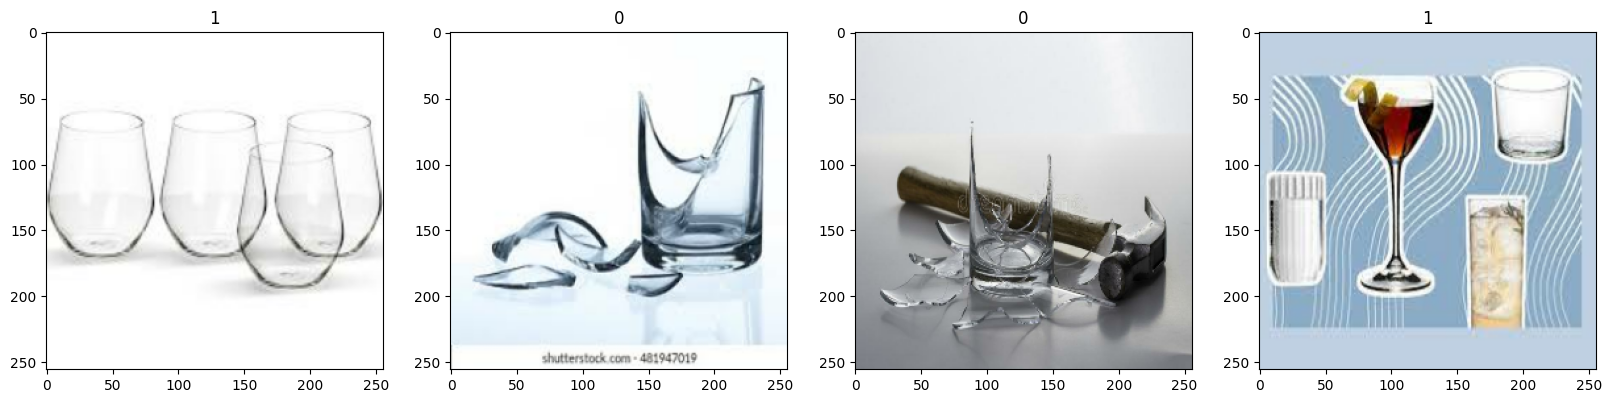

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Wstępne przetwarzanie danych

In [19]:
# przeskalowanie danych, w celu optymalizacji
data = data.map(lambda x,y: (x/255, y)) # funkcja .map umożliwia operacje na całym zestawie danych
data.as_numpy_iterator().next()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(array([[[[0.8576287 , 0.9086091 , 0.9321385 ],
          [0.8576287 , 0.9086091 , 0.9321385 ],
          [0.8576287 , 0.9086091 , 0.9321385 ],
          ...,
          [0.8117647 , 0.8392157 , 0.8784314 ],
          [0.80664915, 0.8404573 , 0.8764944 ],
          [0.8054534 , 0.84074754, 0.87604165]],
 
         [[0.8620711 , 0.9130515 , 0.9365809 ],
          [0.8620711 , 0.9130515 , 0.9365809 ],
          [0.8620711 , 0.9130515 , 0.9365809 ],
          ...,
          [0.8156863 , 0.84313726, 0.88235295],
          [0.81831855, 0.8521268 , 0.88816386],
          [0.81893384, 0.85422796, 0.8895221 ]],
 
         [[0.85471815, 0.90569854, 0.92922795],
          [0.85471815, 0.90569854, 0.92922795],
          [0.85471815, 0.90569854, 0.92922795],
          ...,
          [0.81957173, 0.8470227 , 0.88623846],
          [0.8096831 , 0.8434913 , 0.8795284 ],
          [0.80784315, 0.84313726, 0.8784314 ]],
 
         ...,
 
         [[0.84313726, 0.9098039 , 0.9411765 ],
          [0.84313

In [20]:
train_size = int(len(data)*.7) # część zestawu danych, która będzie odpowiedzalna za trenowanie modelu
val_size = int(len(data)*.2)+1 # część zestwu danych odpowiedzialna za walidacje
test_size = int(len(data)*.1)+1 # część zestawu danych odpowiedzialna za końcowe testy

In [21]:
train_size

16

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Budowa modelu głębokiego uczenia

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 6. Trenowanie

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=60, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/60


2023-02-24 18:41:46.869904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-02-24 18:41:47.752532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-24 18:41:47.760608: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1eb5b470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-24 18:41:47.760621: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-02-24 18:41:47.763652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-24 18:41:47.831323: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

16/16 [==============================] - 5s 75ms/step - loss: 0.7702 - accuracy: 0.5605 - val_loss: 0.6330 - val_accuracy: 0.6812
Epoch 2/60
16/16 [==============================] - 2s 87ms/step - loss: 0.6348 - accuracy: 0.6348 - val_loss: 0.6259 - val_accuracy: 0.6562
Epoch 3/60
16/16 [==============================] - 2s 88ms/step - loss: 0.5903 - accuracy: 0.6797 - val_loss: 0.5688 - val_accuracy: 0.7063
Epoch 4/60
16/16 [==============================] - 2s 88ms/step - loss: 0.4997 - accuracy: 0.7422 - val_loss: 0.5104 - val_accuracy: 0.7312
Epoch 5/60
16/16 [==============================] - 2s 89ms/step - loss: 0.4448 - accuracy: 0.7949 - val_loss: 0.4225 - val_accuracy: 0.7875
Epoch 6/60
16/16 [==============================] - 2s 91ms/step - loss: 0.3598 - accuracy: 0.8418 - val_loss: 0.3515 - val_accuracy: 0.8188
Epoch 7/60
16/16 [==============================] - 2s 88ms/step - loss: 0.3169 - accuracy: 0.8652 - val_loss: 0.3246 - val_accuracy: 0.8125
Epoch 8/60
16/16 [======

# 7. Badanie wydajności, wykaz strat

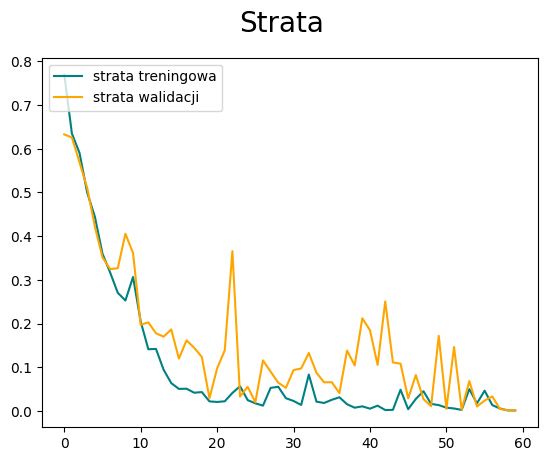

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='strata treningowa')
plt.plot(hist.history['val_loss'], color='orange', label='strata walidacji')
fig.suptitle('Strata', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Badanie wydajności, wykaz dokładności

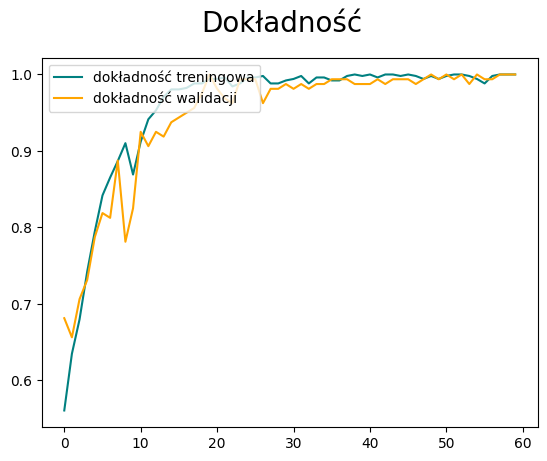

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='dokładność treningowa')
plt.plot(hist.history['val_accuracy'], color='orange', label='dokładność walidacji')
fig.suptitle('Dokładność', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Ocena wydajności modelu

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# 10. Test

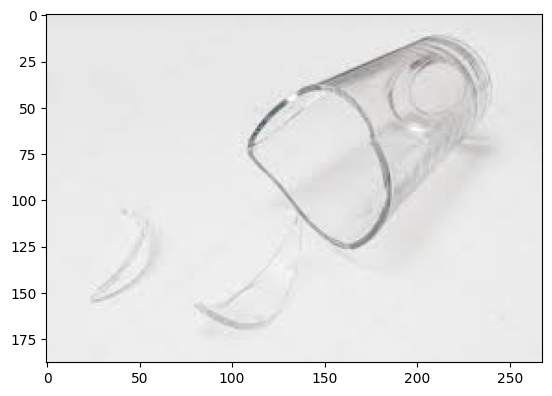

In [84]:
img = cv2.imread('testing/glass_type/broken_8.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

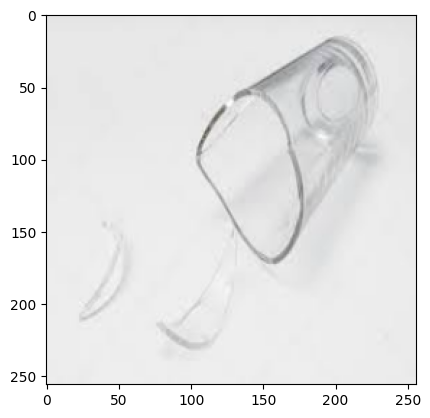

In [85]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [86]:
yhat  = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 10ms/step


In [87]:
yhat

array([[0.77415794]], dtype=float32)

In [88]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część prawidłowa


# 9. Zapis modelu

In [220]:
from tensorflow.keras.models import load_model

In [221]:
model.save(os.path.join('models', 'imageclassicationversionlive.h5'))

In [222]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.h5'))

In [223]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 34ms/step


In [224]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część uszkodzona
